Reference:
https://www.youtube.com/watch?v=eLTLtUVuuy4&t=1560s

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("./data"))

# Any results you write to the current directory are saved as output.

['test_image.jpg', 'test_video.mp4']




# 第一步：导入使用的库
Step:1

load the file and show

In [48]:
import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output, Image, display
%matplotlib inline

读取彩色图像，使用PLT显示图像

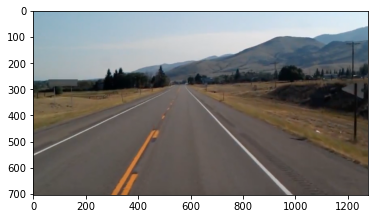

In [2]:
image =cv2.cvtColor(cv2.imread("./data/test_image.jpg"), cv2.COLOR_BGR2RGB) 

plt.imshow(image)
plt.show()

# 第二步：彩色图像变成灰色图像
Step 2:

Gray scale conversion of the image

In [4]:
import numpy as np

lane_image = np.copy(image)
lane_image.shape

(704, 1279, 3)

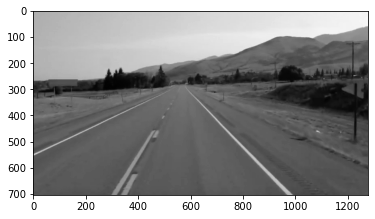

In [5]:
gray = cv2.cvtColor(lane_image, cv2.COLOR_RGB2GRAY)

plt.imshow(gray,cmap='gray')
plt.show()

# 第三步：使用高斯滤波器减少图像噪声

Step 3:

Apply Gausian Blur to reduce the noise in the gray scale image


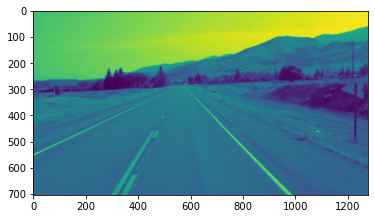

In [6]:
blur = cv2.GaussianBlur(gray, (5,5), 0)

plt.imshow(blur)
plt.show()

# 第四步：边缘检测
Step 4:

apply canny method 

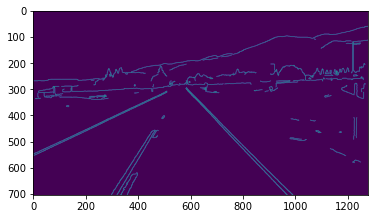

In [49]:
canny = cv2.Canny(blur, 50,100)

plt.imshow(canny)
plt.show()

In [50]:
# put all the previous 3 steps in one function 
# gray scale conversion ==> applying gaussian blur ==> applying canny function

def Canny(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    canny = cv2.Canny(blur, 50, 100)
    
    return canny

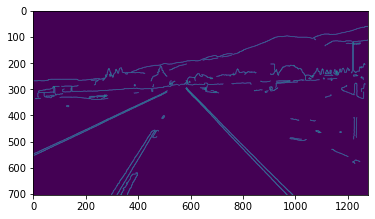

In [51]:
image = cv2.imread("./data/test_image.jpg")
lane_image = np.copy(image)
canny = Canny(lane_image)

plt.imshow(canny)
plt.show()

make a function to find region of interest.

the region where we wanna find the lanes

then, apply bitwise AND operation in order to select just the region of interest

hough transform in order to find straight lines in the image

In [80]:
# make a function to find region of interest. 
# then, apply bitwise AND operation in order to select just the region of interest

def region_of_interest(image):
    height, width = image.shape
#     height = 700
    # 定义一个三角形尺寸
    polygons = np.array([
                        [(0,height), (600, 300), (width, height)]
                        ])
    mask = np.zeros_like(image)
    mask = cv2.fillPoly(mask, polygons, 255)
    # 隔离车道线对应的边缘
    masked_region = cv2.bitwise_and(image, mask)
    
    return masked_region

In [81]:
# function which draws lines as detected lanes in the black image

def display_lines(image, lines):
    line_image = np.zeros_like(image)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line.reshape(4)
            cv2.line(line_image, (x1,y1), (x2,y2), (255,0,0), 10)
    return line_image

# 第五步：霍夫变换（Hough Transform）

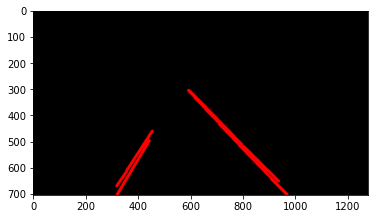

In [87]:
# reading the image and then calling all the functions one by one. 

image = cv2.imread("./data/test_image.jpg")

lane_image = np.copy(image)
canny_image = Canny(lane_image)
cropped_image = region_of_interest(canny_image)

lines = cv2.HoughLinesP(cropped_image, 2, np.pi/180, 100, np.array([]), 40, 5)
line_image = display_lines(lane_image, lines)

plt.imshow(line_image)
plt.show()

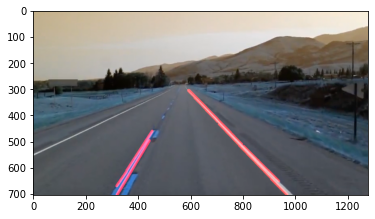

In [88]:
# final step: put it all together
# now combine the above immage containing just the lines in a black image with our original image

combo_image = cv2.addWeighted(lane_image, 1, line_image, 1, 1)

plt.imshow(combo_image)
plt.show()

# 第六步：优化显示

Do some optimization to refine the detection of lanes

In [89]:
def make_coordinates(image, line_parameters):
    print(line_parameters.shape)
    slope, intercept = line_parameters
    
    y1 = int(image.shape[0])
    y2 = int(y1*(3/5))
    x1 = int((y1-intercept)//slope)
    x2 = int((y2-intercept)//slope)
    return np.array([x1,y1,x2,y2])

In [90]:
# global_left_fit_average = []
# global_right_fit_average = []
def average_slope_intercept(image, lines):
    left_fit = []
    right_fit = []
#     global global_left_fit_average
#     global global_right_fit_average
    
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        parameters = np.polyfit((x1,x2), (y1,y2), 1)

        slope = parameters[0]
        intercept = parameters[1]

        if slope < 0:
            left_fit.append((slope, intercept))
        elif slope >= 0:
            right_fit.append((slope, intercept))
            
#     if (len(left_fit) == 0):
#         left_fit_average = global_left_fit_average
#     else:
#         left_fit_average = np.average(left_fit, axis=0)
#         global_left_fit_average = left_fit_average
        
    left_fit_average = np.average(left_fit, axis=0)
    right_fit_average = np.average(right_fit, axis=0)
#     global_right_fit_average = right_fit_average
        
    left_line = make_coordinates(image, left_fit_average)
    right_line = make_coordinates(image, right_fit_average)
        
    return np.array([left_line, right_line])

again doing all the steps

(2,)
(2,)


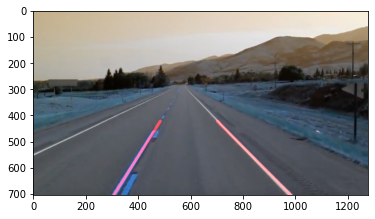

In [91]:
# reading the image and then calling all the functions one by one. 

image = cv2.imread("./data/test_image.jpg")

lane_image = np.copy(image)
canny_image = Canny(lane_image)
cropped_image = region_of_interest(canny_image)

lines = cv2.HoughLinesP(cropped_image, 2, np.pi/180, 100, np.array([]), 40, 5)
averaged_lines = average_slope_intercept(lane_image, lines)
line_image = display_lines(lane_image, averaged_lines)

# final step: put it all together
# now combine the above immage containing just the lines in a black image with our original image

combo_image = cv2.addWeighted(lane_image, 1, line_image, 1, 1)

plt.imshow(combo_image)
plt.show()

now apply the same methods on a video file

which will take each frame of the video file

 and detect the lanes in each frame
 
 finally play all the frames showing lanes detected in a video.

In [ ]:
cap = cv2.VideoCapture("./data/test_video.mp4")

while (cap.isOpened()):
    
    _, frame = cap.read()
    canny_image = Canny(frame)
    cropped_image = region_of_interest(canny_image)
    lines = cv2.HoughLinesP(cropped_image, 2, np.pi/180, 100, np.array([]), 40, 5)
    print(lines)
    averaged_lines = average_slope_intercept(frame, lines)
    line_image = display_lines(frame, averaged_lines)
    combo_image = cv2.addWeighted(frame, 0.8, line_image, 1, 1)

    cv2.imshow("result", combo_image)
    if cv2.waitKey(1) == ord("q"):
        break
cap.release()
cv2.destroyAllWindows()

 * i have commented the lines above, since the kernal dies whenever i try to play video in kaggle notebook,
  but if u run this in pycharm or any other IDE, it works fine.
  
  basically output file shows every frame for 1 ms with lanes detected, and hence the lanes are detected in the video.